In [1]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    plot_results_statistics,
    generate_results,
    plot_results_1d
)

%load_ext autoreload
#%reload_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = .01  # step size

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 3

ACTIVATIONS = tf.nn.leaky_relu
VALIDATION_SPLIT = .1
BATCH_SIZE = 64
N_EPOCHS = 100

xlim = [-.3, .3]

# full covariance matrix, here SPD type
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
x_data = pd.read_csv('./Network-SDE-Inference/Data/TimeSeries&Topologies/HR_stochastic_tf_x_t0_intensity01.csv',encoding='utf-8',header=None)
y_data = pd.read_csv('./Network-SDE-Inference/Data/TimeSeries&Topologies/HR_stochastic_tf_x_t1_intensity01.csv',encoding='utf-8',header=None)
x_data = x_data.values
y_data = y_data.values
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size


data shape (2000000, 3)


In [4]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder,
                                method="euler",
                                diffusivity_type=diffusivity_type)

model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 50)           200         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 50)           200         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 50)           2550        ['GP_mean_hidden_0[0][0]']       
                                                                                

training for 100 epochs with 1800000 data points, validating with 200000
The average loss for epoch 99 is -2.5179943877 

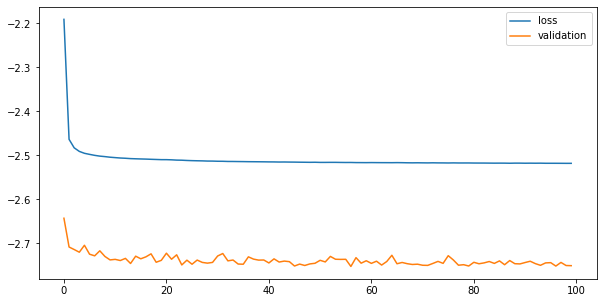

In [5]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size=BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

In [6]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: -2.5179943877433795
Validation loss final: -2.7506528460094177


/Users/lana_g/Desktop/symbolic regression/sde-identification-master/sde/experiment_reports.py:154: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


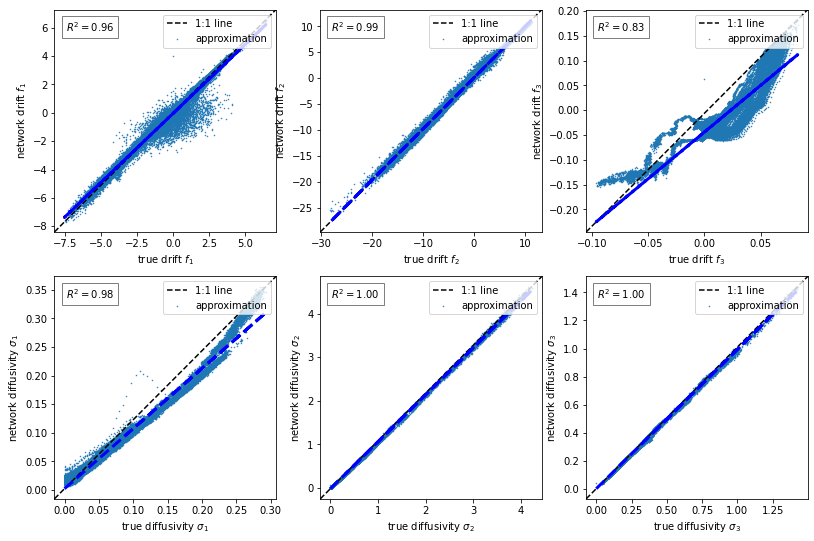

In [7]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, 
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)


# for k in range(2):
#     ax[1, k].set_xlim([0, .5])
#     ax[1, k].set_ylim([0, .5])

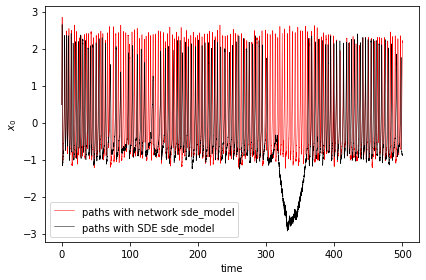

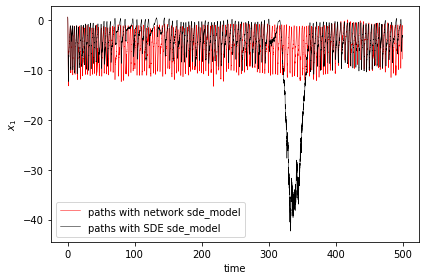

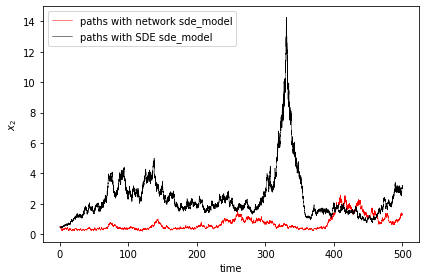

In [11]:
T_steps = 50000
N_iterates = 1

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

# time_steps, paths_true = \
#     generate_results(true_drift_diffusivity,
#                      step_size, x_data, rng,
#                      T_steps=T_steps, N_iterates=N_iterates);
paths_true = pd.read_csv('./Network-SDE-Inference/Data/TimeSeries&Topologies/HR_stochastic_intensity01.csv',encoding='utf-8',header=None)
paths_true = paths_true.values
paths_true = paths_true[0:50000,0:3].reshape(1,-1,3)
for k in range(n_dimensions):
    plot_results_1d(time_steps, paths_network, paths_true, plot_dim=k, linewidth=.5)
    plt.gca().set_ylabel(fr"$x_{k}$");

In [12]:
results = pd.read_csv('../Network-SDE-Inference/Data/Supplementary Data/inferred_HR_results.csv',encoding='utf-8') #the drift part

In [13]:
results = results.values

In [14]:
results.shape

(2000000, 3)

In [15]:
goal = np.zeros((1000000,3)) #50000*20
for i in range(20):
    goal[i*50000:(i+1)*50000,:] = results[i*100000:(i+1)*100000-50000,:]

In [16]:
import sys
from ElementaryFunctionsPool import *
from ElementaryFunctions_Matrix import *

In [17]:
A = pd.read_csv('../Network-SDE-Inference/Data/TimeSeries&Topologies/adj_20nodes.csv',encoding='utf-8',header=None)
A = A.values

In [18]:
data = np.zeros((50000,60))
for i in range(20):
    data[:,i*3:i*3+3] = x_data[i*100000:(i+1)*100000-50000,:]

In [19]:
Dim=3
Nnodes = 20
selfPolyOrder = 3

In [20]:
Matrix = ElementaryFunctions_Matrix(data, Dim, Nnodes, A, selfPolyOrder, coupledPolyOrder = 1, PolynomialIndex = True, TrigonometricIndex = False, \
    ExponentialIndex = True, FractionalIndex = False, ActivationIndex = False, RescalingIndex = False, CoupledPolynomialIndex = True, \
        CoupledTrigonometricIndex = True, CoupledExponentialIndex = True, CoupledFractionalIndex = True, \
            CoupledActivationIndex = True, CoupledRescalingIndex = True)

/Users/lana_g/Desktop/symbolic regression/sde-identification-master/ElementaryFunctionsPool.py:1278: RuntimeWarning: overflow encountered in exp
  tmp[:,1] = tmp[:,1]+A[i,jj]*np.exp(TimeSeries[:,i*dim+1]*TimeSeries[:,jj*dim+1])
/Users/lana_g/Desktop/symbolic regression/sde-identification-master/ElementaryFunctionsPool.py:1278: RuntimeWarning: invalid value encountered in multiply
  tmp[:,1] = tmp[:,1]+A[i,jj]*np.exp(TimeSeries[:,i*dim+1]*TimeSeries[:,jj*dim+1])
/Users/lana_g/Desktop/symbolic regression/sde-identification-master/ElementaryFunctionsPool.py:28: RuntimeWarning: overflow encountered in exp
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
/Users/lana_g/Desktop/symbolic regression/sde-identification-master/ElementaryFunctionsPool.py:28: RuntimeWarning: invalid value encountered in true_divide
  Tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
/Users/lana_g/Desktop/symbolic regression/sde-identification-master/ElementaryFunctionsPool.py:32: RuntimeWarning: divide by 

In [21]:
Matrix = Matrix.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
from sklearn.preprocessing import normalize 
from sklearn.linear_model import LassoLarsCV 
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error 
goal = pd.DataFrame(data = goal[:,0], columns =['X1'])

In [22]:
X = Matrix.copy()
y = goal.copy()
X_mat = X.values 
y_mat = y.values
x_norml1 = []
y_norml1 = []
num = np.shape(X_mat)[1]
num2 = 1
L = np.shape(X_mat)[0]

for i in range(0,num):
    x_norml1.append(sum(abs(X_mat[:,i])))

for i in range(0,num2):
    y_norml1.append(sum(abs(y_mat[:,i])))

X = pd.DataFrame(X)
y = pd.DataFrame(y)

X[X.columns] = normalize(X[X.columns], norm='l1', axis=0)*L
y[y.columns] = normalize(y[y.columns], norm='l1', axis=0)*L

X_col = X.columns 
Xin = X.iloc[:,:]
out = np.array(y)
y1 = (out[:,0])

In [23]:
from math import log
def calculate_aic(n,mse,num_params):
    aic = n * log(mse) + 2 * num_params 
    return aic 

In [24]:
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
def terms_sort_fit(X_lib,Y_goal,intercept):
    reg = LinearRegression(fit_intercept=intercept).fit(X_lib,Y_goal)
#     print(X_lib.columns)
#     if intercept == True:
#         coef['constant'] = reg.intercept_
#         num_params = len(coef)
#     else:
#         num_params = len(coef) 
    num_params = X_lib.shape[1]
    P = X_lib
    Score = reg.score(X_lib,Y_goal)
    yhat = reg.predict(P)
    mse = mean_squared_error(Y_goal, yhat)
    aic = calculate_aic(len(Y_goal), mse, num_params)
    #print('label of function: %.3f' % time)
    #sort = coef.sort_values()
    return Score, mse, aic

In [25]:
reg1 = LassoCV(cv=5, fit_intercept=True, n_jobs=-1, max_iter=4000, normalize=False).fit(Xin,y1)
print(reg1.score(Xin,y1))
print('Best threshold: %.3f' % reg1.alpha_)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 271.0782447300953, tolerance: 219.64928333569762
  tol, rng, random, positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 259.0534805332063, tolerance: 221.18681679215223
  tol, rng, random, positive)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40632.1074462849, tolerance: 277.46611068353127
  positive)


0.9907868888194897
Best threshold: 0.002


In [26]:
for i in range(len(reg1.coef_)):
    reg1.coef_[i] = reg1.coef_[i]*y_norml1[0]/x_norml1[i]
coef1 = pd.Series(reg1.coef_, index = X_col)
imp_coef1 = pd.concat([coef1.sort_values(key=abs).head(int(0)),
                     coef1.sort_values(key=abs).tail(int(10))])
imp_cons = imp_coef1 + (1e-10)
imp_cons['constant'] = reg1.intercept_*y_norml1[0]/L
print("Elementary functions discovered by Phase 1 with constant.")
print(imp_cons)
X = pd.DataFrame()
Score_list = np.zeros(shape=(imp_cons.shape[0],1))
MSE_list = np.zeros(shape=(imp_cons.shape[0],1))
AIC_list = np.zeros(shape=(imp_cons.shape[0],1))
y = goal.copy()
for i in range(1,imp_cons.shape[0]+1):
    if imp_cons.index[-i] != 'constant':
        tmp = Matrix.copy()[imp_cons.index[-i]]
        if i == 1:
            X = Matrix.copy()[imp_cons.index[-i]].values.reshape(-1,1)
            X = pd.DataFrame(X)
        else:
            X = pd.concat([X,tmp],axis=1)
    else:
        Cons = np.ones((y1.shape[0],1))*imp_cons['constant']
        X = pd.DataFrame(Cons)
    Score, mse, aic = terms_sort_fit(X,y,False)
    Score_list[i-1] = Score
    MSE_list[i-1] = mse
    AIC_list[i-1] = aic
    print(Score, mse, aic,imp_cons.index[-i])

Elementary functions discovered by Phase 1 with constant.
x2isigx2jalpha10beta1   -0.063249
expx2                    0.095825
rescx2jMinusx2i         -0.163243
rescx2j                  0.164061
rescx3j                 -0.345717
rescx3jMinusx3i          0.361991
x3                      -0.518358
x2                       0.745734
x1x1x1                  -0.795026
x1x1                     2.639918
constant                 2.971784
dtype: float64
0.0 2.6945005024081587 991214.8448483124 constant
0.002534143734162164 2.687672250843285 988679.4847369272 x1x1
0.004878062215949885 2.6813565613165036 986328.8460527984 x1x1x1
0.7721272911311804 0.6140031285321426 -487747.2555187533 x2
0.9836953310943893 0.043932938557766504 -3125080.931409014 x3
0.9838552239268632 0.04350210724033436 -3134933.8997542523 rescx3jMinusx3i
0.983855224074186 0.043502106843372836 -3134931.9088793625 rescx3j
0.9839298165182168 0.04330111746545612 -3139560.8367903936 rescx2j
0.9839298153169965 0.043301120702144855 -3139

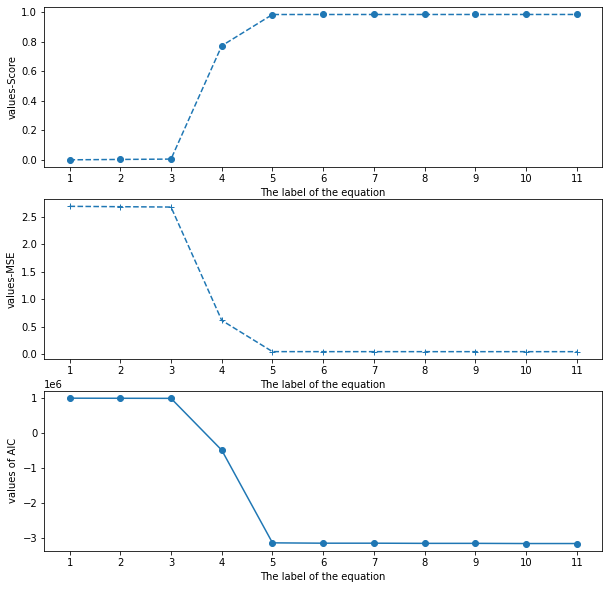

In [27]:
# Visualization
Index = np.arange(1,imp_cons.shape[0]+1,1)
fig = plt.figure(figsize=(10,10))
fig.add_subplot(3,1,1)
l1, = plt.plot(Index,Score_list, marker='o', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-Score')
fig.add_subplot(3,1,2)
l2, = plt.plot(Index,MSE_list, marker='+', linestyle='dashed')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values-MSE')
fig.add_subplot(3,1,3)
l3, = plt.plot(Index,AIC_list, marker='o')
plt.xticks(Index)
plt.xlabel('The label of the equation')
plt.ylabel('values of AIC')
plt.show()